In [28]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn.datasets import make_blobs
from sklearn import metrics

import matplotlib.pyplot as plt

# ### multiprocessing
# from multiprocessing.pool import Pool
# import multiprocessing


import datetime
# import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
# from math import sqrt
from pyspark.mllib.clustering import KMeans
########
from operator import *

from pyspark import SparkContext
# from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
                StructField,ArrayType, DataType, desc, row_number, monotonically_increasing_id
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
                greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum
import pyspark.sql.functions as F

from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf
from scipy.spatial import distance
from pyspark.sql.window import Window

In [29]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "300").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "24g").appName("NPIR_Parallel").getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "False")

In [30]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [31]:
# x1,y1 = make_blobs(n_samples=500000, centers=3, n_features=3,
#                 random_state=1)
# data = pd.DataFrame(x1)
# data['label'] = y1
# # data.head()

In [32]:
# data = shuffle(data)
# data.head()

In [33]:
# data.to_csv('blobs3.csv', index=False)

In [34]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs3.csv')
# data_spark_df.show()
# data_spark_df.count()

500000

In [35]:
# data_spark_df.describe()

In [36]:
# data_spark_df.printSchema()

In [37]:
data_spark_df = data_spark_df.select(data_spark_df.columns[:-1])

In [38]:
points = data_spark_df.count()
# points

In [39]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 10
k = 3 #k: Number of clusters
# count = Cs()
chunk = 200

In [40]:
data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [41]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [42]:
leaderheadr = ['chunkLabel', 'old label']
# leaderheadr = []
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
# leaderheadr

In [43]:
# labelsheader = ('chunkLabel', 'label')
# labelsheader

In [44]:
start = timer()

# labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
# labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    
    del NPIR
    data['labels'] = label

#     # Adding to pyspard label
#     chunklabel = np.full(len(label), ii).tolist()
#     labelDF = [(x, y) for x, y in zip(chunklabel, label)]
#     labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
#     labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:, :-1].T])
    del data
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1
del data_spark
end = timer()
print ("Execution time HH:MM:SS:", timedelta(seconds= end - start))

KeyboardInterrupt: 

In [ ]:
# def Euclidean_distance(a,b,c,d):
#     a = float(a)
#     b = float(b)
#     c = float(c)
#     d = float(d)
#     array1 = np.array([a,b])
#     array2 = np.array([c,d])
#     dist = np.linalg.norm(array1-array2)
#     dist = dist.item()
#     return dist

# Euclidean_distance_spark = udf(lambda x,y,z,t: Euclidean_distance(x,y,z,t), FloatType())
# sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

In [ ]:
start = timer()
# parsedData = leaders.select(['1', '2']).rdd.map(list)
leaders.toPandas().to_csv('leaders.csv')
del leaders

In [ ]:
leaders_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('leaders.csv')
# leaders_spark_df = leaders_spark_df.select('1', '2')
parsedData = leaders_spark_df.select(leaders.columns[2:]).rdd.map(list)
del leaders_spark_df
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
del parsedData
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
# spark_cluster_centroid = sqlContext.createDataFrame(([c.tolist() for c in clusters.centers]),)
# spark_cluster_centroid = spark_cluster_centroid.withColumn('defined_cluster', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)

In [ ]:
dataCol = data_spark_df.columns

In [ ]:
start = timer()
############ Updateing points clusters
for i in range(k):
    if i == 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_spark_df.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        del data_spark_df
        data_cent = data_cent.withColumn('mindist', col('dis' + str(i) + 'th'))
        data_cent
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
    elif i > 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_cent.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))#4
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
data_cent = data_cent.drop('mindist')

# data_cent.show()

In [ ]:
def Min_COl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(Min_COl, IntegerType())

data_cent = data_cent.withColumn('defined_cluster', find_min_val_name(*data_cent.\
            columns[len(dataCol):len(dataCol) + 1 + k]))
# data_cent.show()

In [ ]:
# for c in range(k):
#     data_cent = data_cent.drop('dis' + str(c) + 'th')
# # data_cent.show()

In [ ]:
d = data_cent.select('defined_cluster').toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [77]:
data = pd.read_csv('blobs3.csv')
data.head()

,0,1,2,label
0,-6.350716,-0.693289,-2.582263,2
1,-3.564341,-5.950156,-6.758804,1
2,-2.134308,4.080149,-10.707829,0
3,-1.841365,3.921626,-9.114464,0
4,-1.629309,4.636479,-11.427298,0


In [78]:
data = data[['0','1', '2','label']]

In [79]:
data['new'] = d['defined_cluster'].astype('int8')
data.head()

,0,1,2,label,new
0,-6.350716,-0.693289,-2.582263,2,1
1,-3.564341,-5.950156,-6.758804,1,0
2,-2.134308,4.080149,-10.707829,0,1
3,-1.841365,3.921626,-9.114464,0,1
4,-1.629309,4.636479,-11.427298,0,1


In [80]:
y = data['label']
labelsPred = data['new']

In [81]:
x = data[['0','1', '2']].values
x.shape

(10000, 3)

In [82]:
#printing results
#print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

Measures:
HS: 0.49419403160982095
CS: 0.7382325036336782
VM: 0.5920516749731572
AMI: 0.5919625171455885
ARI: 0.4955113533728531


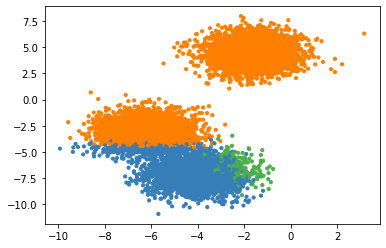

In [83]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()